<a href="https://colab.research.google.com/github/dajebbar/Flowers-Recognition-with-PyTorch/blob/main/Flowers_Recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the dataset from kaggle
Using `opendatasets` and download the dataset [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition)

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

od.download(url)

  1%|          | 5.00M/450M [00:00<00:11, 42.2MB/s]

100%|██████████| 450M/450M [00:01<00:00, 262MB/s]


In [3]:
import os

data_dir = './flowers-recognition/flowers'

os.listdir(data_dir)

['sunflower', 'dandelion', 'rose', 'tulip', 'flowers', 'daisy']

In [4]:
import shutil

shutil.rmtree(data_dir + '/flowers')

In [5]:
os.listdir(data_dir)

['sunflower', 'dandelion', 'rose', 'tulip', 'daisy']

In [6]:
for cls in os.listdir(data_dir):
  print(f"{cls}: {len(os.listdir(data_dir + '/' + cls))}")

sunflower: 734
dandelion: 1055
rose: 784
tulip: 984
daisy: 769


## Import the dataset into PyTorch

Use the `ImageFolder` class from `torchvision`.

In [7]:
from torchvision.datasets import ImageFolder

In [8]:
dataset = ImageFolder(data_dir)

In [9]:
len(dataset)

4323

In [10]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F8EF7C48A90>, 0)

In [11]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [12]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

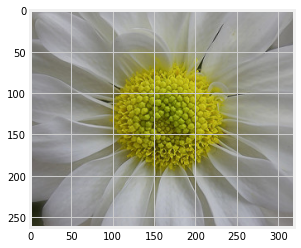

In [13]:
img, _ = dataset[0]
plt.imshow(img)

In [14]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

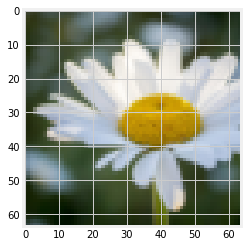

In [15]:
img, _ = dataset[170]
plt.imshow(img.permute(1,2,0))

In [16]:
val_pct = .1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [17]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(3891, 432)

In [18]:
from torch.utils.data import  DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size,
                    num_workers=2, pin_memory=True)

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

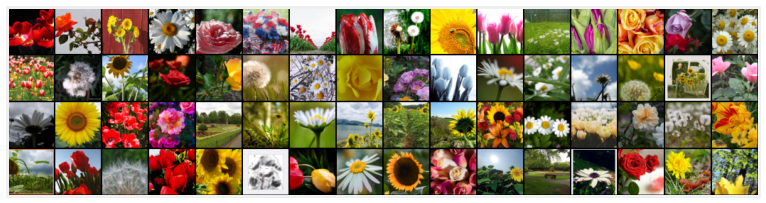

In [20]:
show_batch(train_dl)

## GPU Utilities

In [21]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
images, labels = dataset[0]

In [24]:
images.device

device(type='cpu')

In [25]:
img_gpu = to_device(images, device)
img_gpu.device

device(type='cuda', index=0)

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model & Training Utilities

In [27]:
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [29]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [30]:
model = to_device(ResNet9(3, len(dataset.classes)), device)

model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [31]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [32]:
torch.cuda.empty_cache()

for batch in train_dl:
  images, labels = batch
  print('images.shape ', images.shape)
  print('images.device ', images.device)

  preds = model(images)

  print('preds.shape ', preds.shape)
  print('preds ', preds)
  break

images.shape  torch.Size([64, 3, 64, 64])
images.device  cuda:0
preds.shape  torch.Size([64, 5])
preds  tensor([[ 1.0766e+00,  1.6363e+00, -6.4588e-01,  3.9421e+00,  4.0266e+00],
        [-3.8697e-01,  2.4440e+00, -1.1104e+00,  3.4151e+00,  5.6751e+00],
        [ 3.2844e-01,  2.2725e+00, -1.1423e+00,  2.0304e+00,  3.8465e+00],
        [ 5.3768e-01,  1.9875e+00, -1.9177e-01, -5.7120e-01,  2.2272e+00],
        [ 1.1309e+00,  1.3129e+00, -6.5019e-01,  2.6333e+00,  2.1424e+00],
        [-1.1782e+00,  3.1617e+00, -2.7227e+00,  1.8766e+00,  4.1164e+00],
        [ 1.9194e+00,  1.7094e+00, -2.6657e+00,  1.9416e+00,  3.8773e+00],
        [ 6.5079e-01,  2.2243e+00, -1.3943e+00,  1.9321e+00,  5.5803e+00],
        [-4.9529e-02,  6.4351e-01, -6.3452e-01,  6.1647e-01,  3.0333e+00],
        [-1.5003e+00,  1.4306e+00, -2.9115e+00,  2.6721e+00,  5.9088e+00],
        [ 1.6801e+00,  1.0417e+00, -3.0040e+00,  5.2014e+00,  5.7895e+00],
        [ 5.2666e-01,  1.6815e+00,  3.3223e-01,  2.6749e+00,  3.6690e+0

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


## Training

In [33]:
history = [evaluate(model, val_dl)]
history 

[{'val_acc': 0.20238097012043, 'val_loss': 1.6082724332809448}]

In [34]:
history += fit(5, 0.001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.2944, val_loss: 0.8873, val_acc: 0.6644
Epoch [1], train_loss: 0.9310, val_loss: 1.0304, val_acc: 0.6376
Epoch [2], train_loss: 0.8061, val_loss: 0.7261, val_acc: 0.7307
Epoch [3], train_loss: 0.7560, val_loss: 0.7609, val_acc: 0.7240
Epoch [4], train_loss: 0.6756, val_loss: 0.7662, val_acc: 0.7068


In [35]:
history += fit(5, 0.001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.7944, val_loss: 0.7036, val_acc: 0.7426
Epoch [1], train_loss: 0.6365, val_loss: 0.8664, val_acc: 0.6711
Epoch [2], train_loss: 0.5912, val_loss: 0.6223, val_acc: 0.7738
Epoch [3], train_loss: 0.5370, val_loss: 0.7617, val_acc: 0.7649
Epoch [4], train_loss: 0.4940, val_loss: 0.5265, val_acc: 0.7805


In [36]:
history += fit(5, 0.0001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3445, val_loss: 0.4667, val_acc: 0.8259
Epoch [1], train_loss: 0.3101, val_loss: 0.4650, val_acc: 0.8177
Epoch [2], train_loss: 0.2855, val_loss: 0.4550, val_acc: 0.8430
Epoch [3], train_loss: 0.2769, val_loss: 0.4515, val_acc: 0.8512
Epoch [4], train_loss: 0.2697, val_loss: 0.4635, val_acc: 0.8475


In [37]:
history += fit(5, 0.001,model, train_dl, val_dl)

Epoch [0], train_loss: 0.2485, val_loss: 0.4396, val_acc: 0.8519
Epoch [1], train_loss: 0.2315, val_loss: 0.4528, val_acc: 0.8482
Epoch [2], train_loss: 0.2317, val_loss: 0.4603, val_acc: 0.8237
Epoch [3], train_loss: 0.2350, val_loss: 0.4353, val_acc: 0.8519
Epoch [4], train_loss: 0.2378, val_loss: 0.4453, val_acc: 0.8408


In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

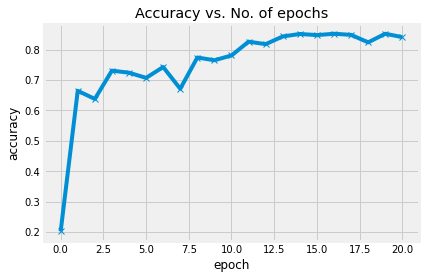

In [39]:
plot_accuracies(history)

In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

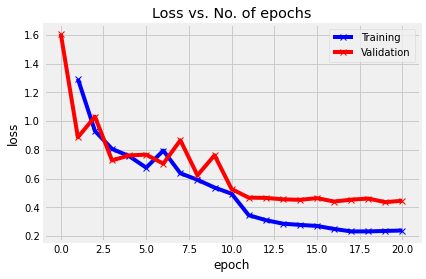

In [41]:
plot_losses(history)

## Test with individual images

In [42]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [43]:
def show_img(img, label):

  plt.imshow(img.permute(1,2,0))

  target = dataset.classes[label]
  pred = predict_image(img, model, dataset.classes)
  
  print('target label: ', target)
  print('predict label: ', pred)

target label:  dandelion
predict label:  dandelion


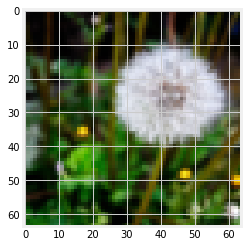

In [44]:
show_img(*val_ds[0])

target label:  dandelion
predict label:  dandelion


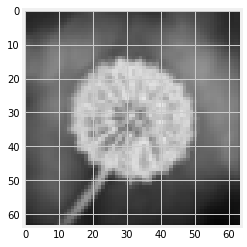

In [45]:
show_img(*val_ds[250])


target label:  dandelion
predict label:  dandelion


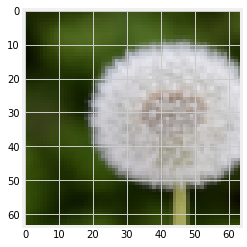

In [46]:
show_img(*val_ds[19])


target label:  rose
predict label:  tulip


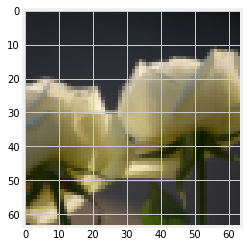

In [47]:
show_img(*val_ds[9])

target label:  tulip
predict label:  tulip


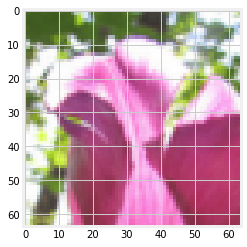

In [48]:
show_img(*val_ds[188])

target label:  rose
predict label:  tulip


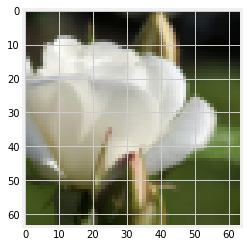

In [49]:
show_img(*val_ds[300])

## Save the Model

In [50]:
torch.save(model.state_dict(), 'flowers-recognition-resnet9.pth')

## Transfer Learning

In [108]:
from torchvision import models

class ResNetModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [109]:
model = to_device(ResNetModel(len(dataset.classes), pretrained=True), device)

#### Recreate the dataset

In [110]:
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                            tt.RandomCrop(img_size),
                                            tt.ToTensor(),
                                            tt.Normalize(*imagenet_stats)]))

In [111]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(3891, 432)

In [112]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size,
                    num_workers=2, pin_memory=True)

In [113]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [114]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [115]:
history = [evaluate(model, val_dl)]
history 

[{'val_acc': 0.2395833432674408, 'val_loss': 1.990954041481018}]

In [116]:
history += fit_one_cycle(10, 0.0001, model, 
              train_dl, val_dl,
              weight_decay=0.01, grad_clip=0.1,opt_func=torch.optim.Adam)


Epoch [0], train_loss: 1.2236, val_loss: 0.5294, val_acc: 0.8423



Epoch [1], train_loss: 0.3074, val_loss: 0.2743, val_acc: 0.8936



Epoch [2], train_loss: 0.1233, val_loss: 0.2663, val_acc: 0.9018



Epoch [3], train_loss: 0.0689, val_loss: 0.3119, val_acc: 0.9062



Epoch [4], train_loss: 0.0616, val_loss: 0.2738, val_acc: 0.9174



Epoch [5], train_loss: 0.0355, val_loss: 0.2935, val_acc: 0.9115



Epoch [6], train_loss: 0.0258, val_loss: 0.2310, val_acc: 0.9405



Epoch [7], train_loss: 0.0115, val_loss: 0.2254, val_acc: 0.9308



Epoch [8], train_loss: 0.0081, val_loss: 0.2478, val_acc: 0.9330



Epoch [9], train_loss: 0.0055, val_loss: 0.2326, val_acc: 0.9375


### Visualization

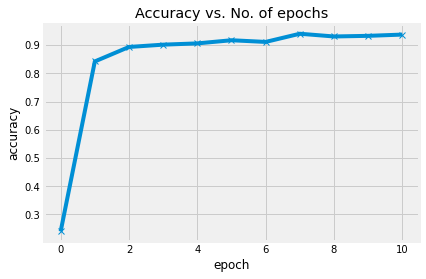

In [117]:
plot_accuracies(history)

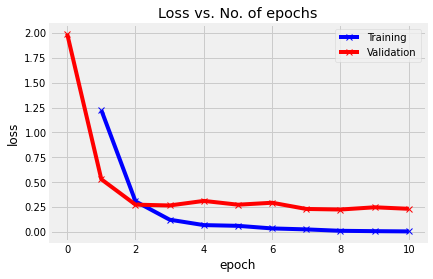

In [118]:
plot_losses(history)

In [121]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

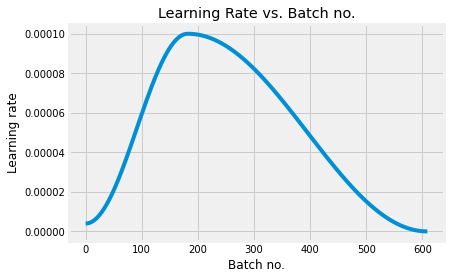

In [122]:
plot_lrs(history)

### Test with individual images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


target label:  tulip
predict label:  tulip


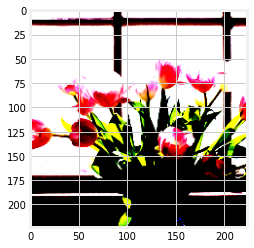

In [123]:
show_img(*val_ds[9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


target label:  rose
predict label:  rose


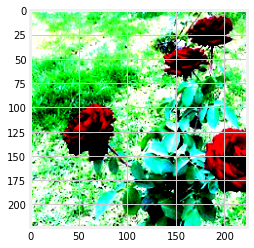

In [124]:
show_img(*val_ds[300])